In [1]:
from alpha_vantage.foreignexchange import ForeignExchange
import matplotlib.pyplot as plt
cc = ForeignExchange(key='OGRPFV5D58LC77OL',output_format='pandas')
import pandas as pd
from datetime import datetime
import numpy as np
from numpy.polynomial.polynomial import polyfit

# get_currency_exchange_intraday()
# get_currency_exchange_daily()
# get_currency_exchange_weekly()
# get_currency_exchange_monthly()
#data_daily, meta_data = cc.get_currency_exchange_daily(from_symbol='EUR',to_symbol='USD', outputsize='full')
df60, meta_data = cc.get_currency_exchange_intraday(from_symbol='EUR',to_symbol='USD',interval='60min', outputsize='full')
dfd, meta_data = cc.get_currency_exchange_daily(from_symbol='EUR',to_symbol='USD', outputsize='full')
dfw, meta_data = cc.get_currency_exchange_weekly(from_symbol='EUR',to_symbol='USD', outputsize='full')
pd.set_option('display.max_rows', 100)

In [2]:
df60.reset_index(inplace=True) #reset index to get timestamp out
df60.columns = ['timestamp','open','high','low','close'] #Make sure column names are legit    
df60 = df60[df60.timestamp.dt.weekday < 5] #Filter out all weekend data
df60['index'] = np.arange(len(df60)) #create an index 

dfd.reset_index(inplace=True) #reset index to get timestamp out
dfd.columns = ['timestamp','open','high','low','close'] #Make sure column names are legit    
dfd = dfd[dfd.timestamp.dt.weekday < 5] #Filter out all weekend data
dfd['index'] = np.arange(len(dfd)) #create an index 

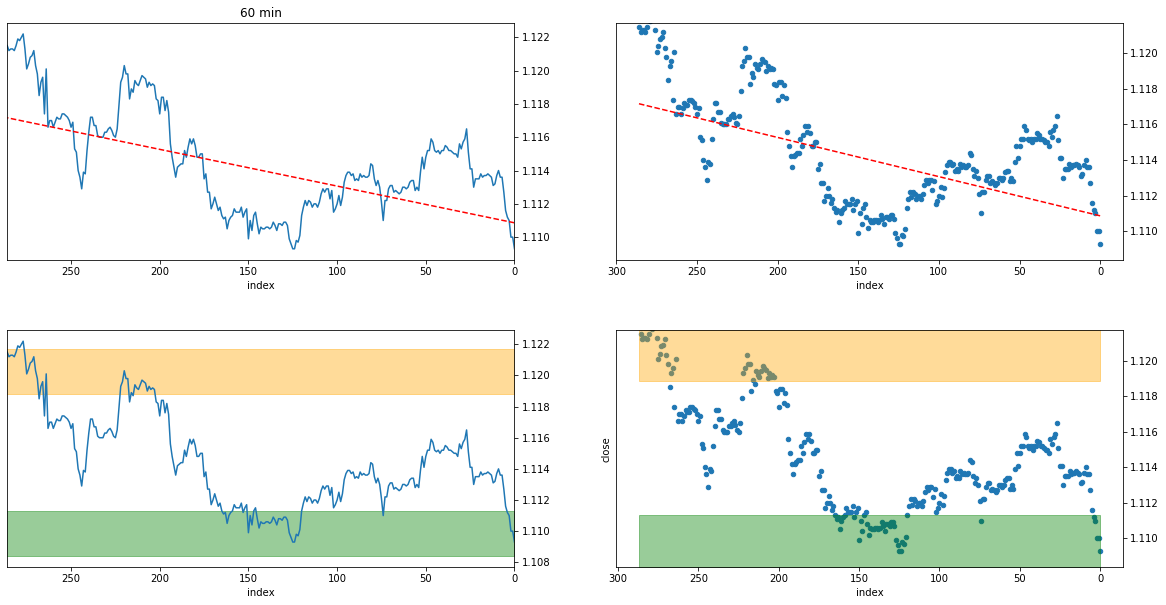

In [3]:
_low = 'low'
_high = 'high'
_open = 'open'
_close = 'close'
_val = 'low'

def Set_Ylim(df,ax):
    ax.set_ylim([df[_val].min(),df[_val].max()])

def Plot_HiLowBars(df,ax):
    ax.fill_between([0,df['index'].count()],df[_low].quantile(0.2), df[_low].min(),alpha=0.4,color='green')
    ax.fill_between([0,df['index'].count()],df[_low].max(),df[_low].quantile(0.9),alpha=0.4,color='orange')
    ax.yaxis.tick_right()
    ax.invert_xaxis()

def Plot_errorLine(df,ax):
    b, m = polyfit(df['index'], df[_low], 1)
    ax.plot(df['index'], b + m * df['index'], 'r--')
    ax.yaxis.tick_right()
    ax.invert_xaxis()

    
#Set the main figure proportions
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.3)

# Divide the figure into a 2x2 grid, and set sections to ax1 and ax2
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


df60.plot(x='index', y='close', ax=ax1, legend=False)
df60.plot(x='index', y='close', ax=ax2, kind = 'scatter')
df60.plot(x='index', y='close', ax=ax3, legend=False)
df60.plot(x='index', y='close', ax=ax4, kind = 'scatter')

ax2.yaxis.set_label_text("")
ax1.set_title('60 min')

Set_Ylim(df60,ax2)
Set_Ylim(df60,ax4)

Plot_errorLine(df60,ax1)
Plot_errorLine(df60,ax2)

Plot_HiLowBars(df60,ax3)
Plot_HiLowBars(df60,ax4)



In [76]:
#df = df60.copy()
#df60[df60.timestamp > '2020-01-12 18:00:00']
#df[df['timestamp'].isin(['2020-01-13','2020-01-07'])]
#df.mean()
#pieces = [df[:1], df[:3], df[4:]] # Chop a datraframe into pieces
#df['day'] = df['timestamp'].dt.day_name() #Create a column of day names
#df.groupby('day')
#df.set_index('day', inplace=True)
gf = df.groupby('day').sum()
gf

,open,high,low,close,index
day,,,,,
Friday,71.2458,71.2710,71.2069,71.2408,8928
Monday,53.5419,53.5649,53.5198,53.5468,7656
Thursday,80.2841,80.3127,80.2351,80.2766,10620
Tuesday,53.5196,53.5383,53.4885,53.5144,6504
Wednesday,61.3051,61.3297,61.2717,61.3040,7333


In [5]:
#df60.to_csv('filtered.csv')